In [1]:
import os, sys
%pylab inline
import pandas as pd
from importlib import reload
from matplotlib.gridspec import GridSpec
import matplotlib.colors as mcolors

Populating the interactive namespace from numpy and matplotlib


In [2]:
import logging
logging.basicConfig(level=logging.WARNING)
logger = logging.getLogger("make_figures")

In [3]:
plt.style.use("default")
plt.rcParams["figure.figsize"]=(8,5)    

In [4]:
import inputs, classifiers, run

In [5]:
set_alpha = lambda col, al: tuple(list(col[:3]) + [al])

def get_ylim(y,scale=1.1):
    min_y = np.min(y)
    max_y = np.max(y)
    dy    = max_y - min_y
    return [min_y - dy*scale/2, max_y + dy*scale/2]

def plot_timecourses(X,y,t, style="-"):
    m = [mean(X[y>0,:],axis=0), mean(X[y<0,:],axis=0)]
    s = [std(X[y>0,:],axis=0),   std(X[y<0,:],axis=0)]
    for i, (col, lab) in enumerate([([1,0,0], "corr"),([0,0,1], "anti-corr")]):
        fill_between(t, m[i]-s[i], m[i]+s[i], color=col + [0.2])
        plot(t, m[i], style, color=col, label=lab);

def vline(t, ax = None, *args, **kwargs):
    yl = ylim()
    plot([t,t], yl, *args, **kwargs)
    ylim(yl)

def hline(t, ax = None, *args, **kwargs):
    xl = xlim()
    plot(xl, [t,t], *args, **kwargs)
    xlim(xl)    

In [6]:
def load_results(pairs, window_size, whiskers, clf = "lasso_lars_no_intercept", dt = -1, response_threshold = 1.0, min_resp_trials = 0.5, base_name = "filt_nsub145_100x", max_load = 100, full = False):
    if "filt" in base_name:
        logger.info("Loading datasets which uses only responsive ROIs.")
        name = f"{base_name}_{pairs}_{int(window_size*1000)}ms_W{whiskers}DT_rt{response_threshold:1.3f}_mrt{min_resp_trials}".replace("DT", f"_dt{dt}" if dt > 0 else "")
    else:
        logger.info("Loading datasets which uses all ROIS.")
        name = f"{base_name}_{pairs}_{int(window_size*1000)}ms_W{whiskers}"
        
    logger.info(f"{name=}")
    config = {"output_prefix":"", "raw":False, "mock":"null", "classifier":clf}
    output_dir = run.get_output_folder_name(config, head = f"data/sweeps/{name}")
    logger.info(output_dir)
    records = []
    for f in os.scandir(output_dir):
        if f.is_file() and f.name.endswith(".csv"):
            records.append(pd.read_csv(f))
        if len(records) >= max_load:
            break
    logger.info(f"Read {len(records)} csv files, with {max_load=}")
    df = pd.concat(records)
    logger.info(f"Created dataframe with {len(df)} rows.")
    col_names = list(df.columns)
    logger.info(f"Columns: {col_names}")
    df.head()
    logger.info(f"Accuracy at 3 sec. using all ROIs at 2 Hz: {mean(df[(df.start_time == 3) & (df.shuf == 0) & (df.freq==2)]['test_score']):1.3f}")
    # Set a flag for whether this was a shuffle run or not.
    df.loc[df.shuf>0, "shuf"]=1
    
    if "filt" in base_name:
        df2 = df.groupby(['shuf','freq','start_time'], as_index=False).agg({'train_score':['mean', 'std'], 'test_score':['mean', 'std'], 'n_sub':['mean','std','count']})
    else:
        df2 = df.groupby(['n_sub','shuf','freq','start_time'], as_index=False).agg({'train_score':['mean', 'std'], 'test_score':['mean', 'std']})
        
    df2.columns = [c  + ("_" if len(d) else "") + d for (c,d) in df2.columns.to_flat_index()]
    return (df2, df) if full else df2


In [7]:
def get_best_coefs(config, clf, full = False, compute_accuracy = False, search = None):
    X, y, t, X_sub, ind_glom, ind_t = inputs.generate_input_for_config(config, return_full = True)
    if search is None:
        search = run.get_pipeline(classifier=clf, return_pipe=False)
    if compute_accuracy:
        train_acc, test_acc = run.run_single(config, search)
        print(f"{train_acc=:1.3f}, {test_acc=:1.3f}")
    if len(X):
        search.fit(X,y)
        best_coefs = search.best_estimator_["clf"].coef_
    else:
        print("X was empty.")
        best_coefs = []
    return best_coefs if not full else (best_coefs, (X, y, t, X_sub, ind_glom, ind_t))

# Decoding at 20 Hz

In [8]:
def plot_results(df2, start_time=3):

    freq_cols = {
        (0,2): "blue", (1,2):"blue",
        (0,20):"red", (1,20):"red",
    }
    
    df_sub  = {(sh,freq):df2[(df2.start_time == start_time) & (df2.freq==freq) & (df2.shuf==sh)].sort_values(by=["n_sub"]) for sh in [0,1] for freq in [2,20]}
    h,xx,yy,ss = [],{},{},{}
    for (sh,freq),col in sorted(freq_cols.items()):
        x = df_sub[sh,freq]["n_sub"].values
        ym= df_sub[sh,freq]["test_score_mean"]
        ys= df_sub[sh,freq]["test_score_std"]

        fill_between(x, ym-ys, ym+ys, color=list(mcolors.to_rgb(col)) + [0.2])    
        h.append(plot(x,ym,"--" if sh else "-", color=col, label=f"{freq}Hz " + ("sh" if sh else "")))

    xlim(x[0],x[-1]); ylim(0.3,1)
    return h 

In [9]:
whiskers = "yes"
window_size = 2
start_time  = 4
clf  = "lasso_lars_no_intercept"
dfAB = load_results("AB", window_size, whiskers, clf, base_name = "all_100x")
dfCD = load_results("CD", window_size, whiskers, clf, base_name = "all_100x")
dfEF = load_results("EF", window_size, whiskers, clf, base_name = "all_100x")

In [10]:
freq = 20
inputs.logger.setLevel(logging.INFO)
configCD = inputs.Config(seed=0,shuf=0, window_size = window_size, n_sub = 145, freq=freq, pairs="CD", whiskers=whiskers, start_time = start_time, response_threshold = 0, min_resp_trials=0)
best_coefs, (X,y,t,X_sub,ind_glom,ind_t) = get_best_coefs(configCD, clf, full = True)

basic_decoding.pdf


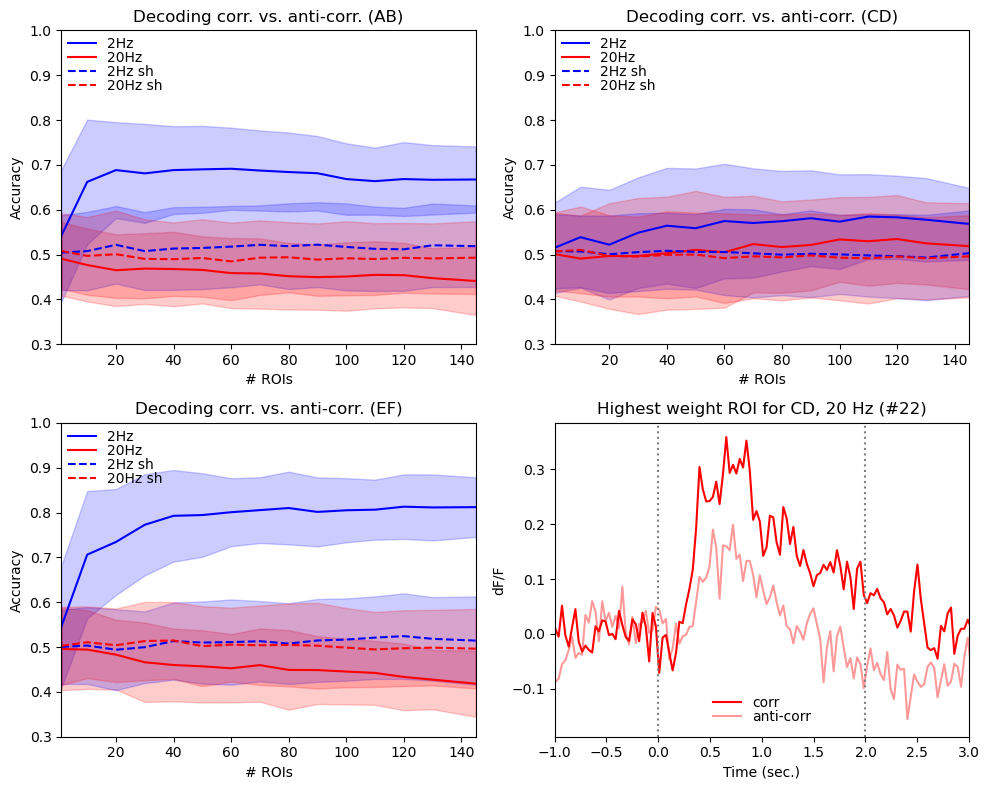

In [11]:
corr_cols = {"corr":"red",
             "acorr":"plum"}
figure(figsize=(10,8))
subplot(2,2,3); hEF = plot_results(dfEF, start_time); xlabel("# ROIs"); ylabel("Accuracy"); title("Decoding corr. vs. anti-corr. (EF)")
legend(frameon=False, labelspacing=0,loc="upper left", fontsize=10, borderpad=0)
subplot(2,2,1); hAB = plot_results(dfAB, start_time); xlabel("# ROIs"); ylabel("Accuracy"); title("Decoding corr. vs. anti-corr. (AB)")
legend(frameon=False, labelspacing=0,loc="upper left", fontsize=10, borderpad=0)
subplot(2,2,2); hCD = plot_results(dfCD, start_time); xlabel("# ROIs"); ylabel("Accuracy"); title("Decoding corr. vs. anti-corr. (CD)")
legend(frameon=False, labelspacing=0,loc="upper left", fontsize=10, borderpad=0)
subplot(2,2,4)
plot(t-3, mean(X_sub[y>0],axis=0)[argmax(best_coefs)], color=corr_cols["corr"], label="corr")
plot(t-3, mean(X_sub[y<0],axis=0)[argmax(best_coefs)], color=list(mcolors.to_rgb(corr_cols["corr"]))+[0.4], label="anti-corr")
legend(frameon=False, fontsize=10, loc="lower center", labelspacing=0)
yl = ylim(); plot([0,0],yl, ":",color="gray"); plot([2,2],yl, ":",color="gray"); ylim(yl)
title(f"Highest weight ROI for CD, 20 Hz (#{argmax(best_coefs)})")
xlabel("Time (sec.)"); ylabel("dF/F");
xlim(-1,3)
tight_layout()
file_name = "basic_decoding.pdf"
print(file_name)
savefig(file_name, bbox_inches = "tight")

# Effect of Window Size and Nonlinear Decoding

In [12]:
window_sizes = [0.025, 0.1, 2]
cm_wsz   = cm.cool
wsz_cols = {0.025:cm_wsz(0.2), 0.05:cm_wsz(0.4), 0.1:cm_wsz(0.6), 2:cm_wsz(1.)}
wsz_labs = {0.025:"25 ms", 0.05:"50 ms", 0.1:"100 ms", 2:"2 sec"}

In [13]:
xysnf = {}
clf_aliases = {"lasso":"lasso_lars_no_intercept",
               "l1":"svc_linear_l1_no_intercept",
               "l2":"svc_linear_no_intercept",
               "poly":"svc_poly",
               "rbf":"svc_rbf"}
df_filt_wsz = {(clfa, pair, wsz):load_results(pair, wsz, "yes", clf, dt = 0.2, response_threshold = rt, min_resp_trials = mrt, base_name = "filt_100x")
               for pair in ["AB", "CD", "EF"] for wsz in window_sizes for (rt,mrt) in [(1.0, 0.75)] for (clfa,clf) in clf_aliases.items()}
for (clfa, pair, wsz), df in df_filt_wsz.items():
    for (sh, freq) in [(0,2),(0,20),(1,2),(1,20)]:
        xysnf[clfa,pair,wsz,sh,freq] = df[(df.shuf==sh) & (df.freq==freq)][["start_time", "test_score_mean", "test_score_std", "n_sub_mean"]].sort_values(by="start_time").to_numpy().T

In [14]:
def plot_wsz_results(clfa, response_threshold = 1.0, min_resp_trials = 0.75, what_to_plot = "acc", show_error_bars = False, show_shuf = False, min_xlabs = True, min_ylabs = True, odour_onset_time = 3, export_figure = False, yl = None, which_sizes = window_sizes):
    sh_freq = [(0,2),(0,20)] + ([(1,2),(1,20)] if show_shuf else [])
    rt, mrt = response_threshold, min_resp_trials    
    
    figure(figsize=(10, 5 + (show_shuf)*5))
    gs = GridSpec(4 if show_shuf else 2, 3)
    yl = {"acc":(0,1), "counts":(-5,145)}[what_to_plot] if not yl else yl
    ax = {}    
    for ip, pair in enumerate(["AB", "CD","EF"]):
        for wsz in which_sizes:
            for isf, (sh, freq) in enumerate(sh_freq):
                xx,yy,ss,nn = xysnf[clfa,pair, wsz,sh,freq]
                uu = xx - odour_onset_time + wsz 
                ax[isf,ip] = subplot(gs[isf,ip]) if (isf,ip) not in ax else ax[isf,ip]
                (what_to_plot == "acc") and show_error_bars and ax[isf,ip].fill_between(uu, yy - ss,  yy + ss, color=list(mcolors.to_rgb(wsz_cols[wsz]))+[0.2])            
                ax[isf,ip].plot(uu, nn if what_to_plot == "counts" else yy, "-", markersize=3, color=wsz_cols[wsz], label=wsz_labs[wsz], linewidth=1.5)
                ax[isf,ip].plot([0,0],yl,":",color="gray");
                ax[isf,ip].set_ylim(yl)
                
    for ip, pair in enumerate(["AB", "CD", "EF"]):
        for isf, (sh, freq) in enumerate(sh_freq):
            ax[isf,ip].set_ylim(yl)
            ax[isf,ip].set_xticks(arange(0,13,1)-3)
            (what_to_plot == "acc") and ax[isf,ip].set_yticks(arange(0,1.01,0.1))
            (what_to_plot != "acc") and ax[isf,ip].set_yticks(list(range(0,150,25))+[145])
            (what_to_plot == "acc") and ax[isf,ip].plot(ax[isf,ip].get_xlim(), [0.5, 0.5], ":", color="gray")
            (isf != 3) and (isf != len(sh_freq)-1) and min_xlabs and ax[isf,ip].set_xticklabels([])
            (ip  != 0) and min_ylabs and ax[isf,ip].set_yticklabels([])    
            (ip  == 0) and ax[isf,ip].set_ylabel(f"{freq}Hz" + (" (sh) " if sh else ""))
            (isf == 0) and ax[isf,ip].set_title(pair)
            (isf == len(sh_freq)-1) and ax[isf,ip].set_xlabel("Time (sec.)")
            (what_to_plot == "counts") and ax[isf, ip].grid(True, linestyle=":")
            ax[isf,ip].set_xlim(-1,5)
            ax[isf,ip].set_ylim(yl)
            
    ax[0,0].legend(frameon=False, fontsize=8, labelspacing=0, borderpad=0)
            
    tight_layout(h_pad=0)
    if what_to_plot == "acc":
        ttl = f"Accuracy using the '{clf_aliases[clfa]}' classifier\nfor response threshold = {rt:1.1f} SDs and min. responsive trials = {mrt:1.2f}"
    else:
        ttl = f"Number of responsive cells for response threshold = {rt:1.1f} SDs and min. responsive trials = {mrt:1.2f}"
    suptitle(ttl, y = 1.05)

    if export_figure:
        file_name = f"{what_to_plot}_{rt:1.1f}_{mrt:1.2f}"
        if what_to_plot == "acc":
            file_name +=f"_{clfa}"
        file_name +=".pdf"
        savefig(file_name, bbox_inches="tight")
        print(f"Wrote {file_name}")

## Plot the counts of responsive cells

Wrote counts_1.0_0.75.pdf


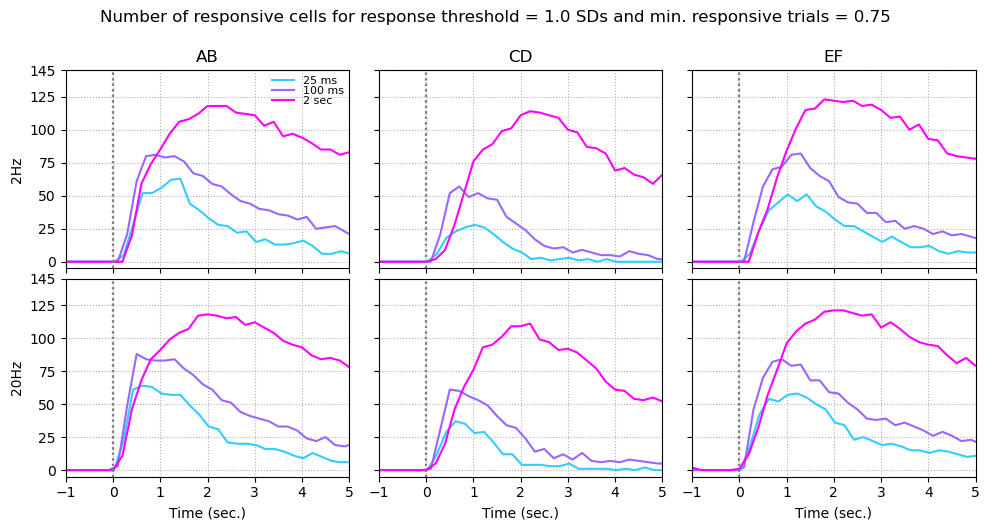

In [15]:
plot_wsz_results("lasso", what_to_plot = "counts", which_sizes = [0.025,0.1,2], export_figure = True)

## Decoding using the  Lasso

Wrote acc_1.0_0.75_lasso.pdf


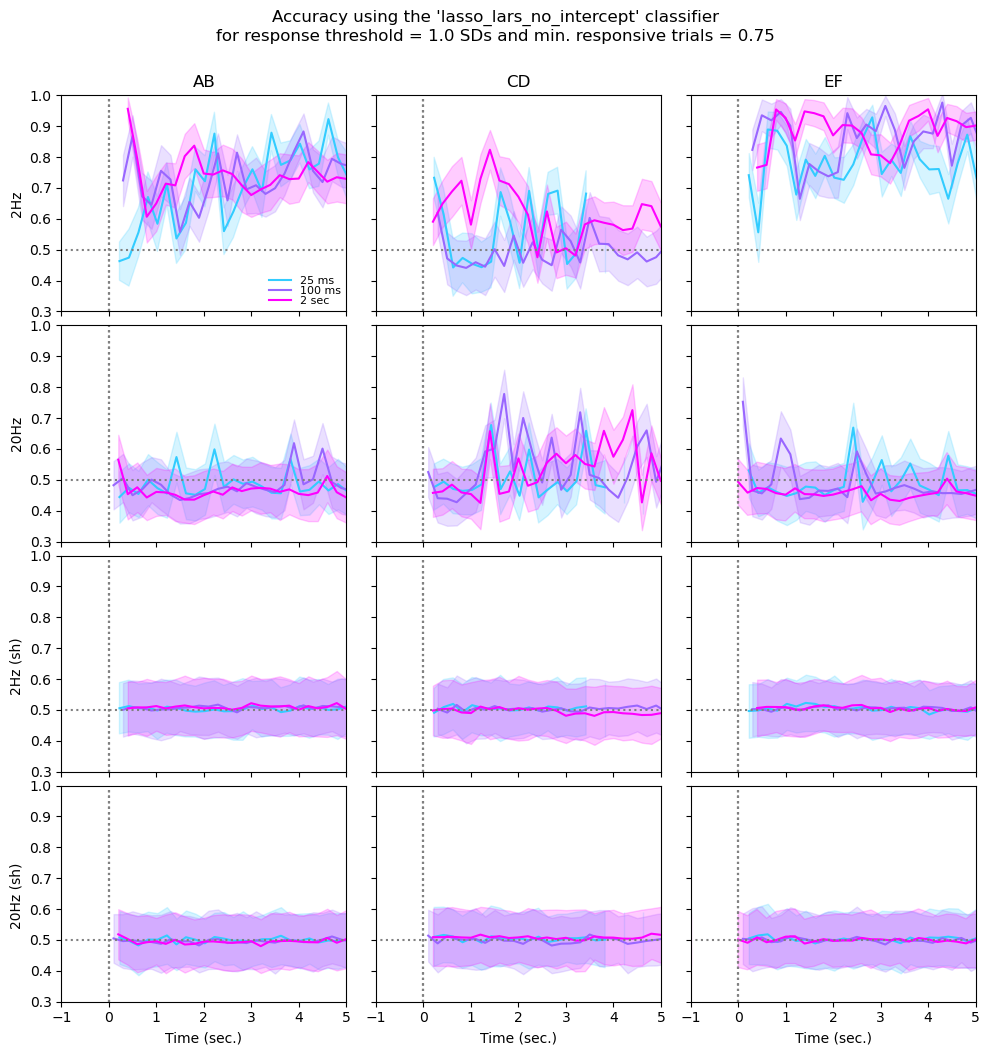

In [27]:
plot_wsz_results("lasso", what_to_plot = "acc", yl = (0.3, 1), show_shuf = True, show_error_bars = True, which_sizes = [0.025,0.1,2], export_figure = True)

## Linear kernels: l2

Wrote acc_1.0_0.75_l2.pdf


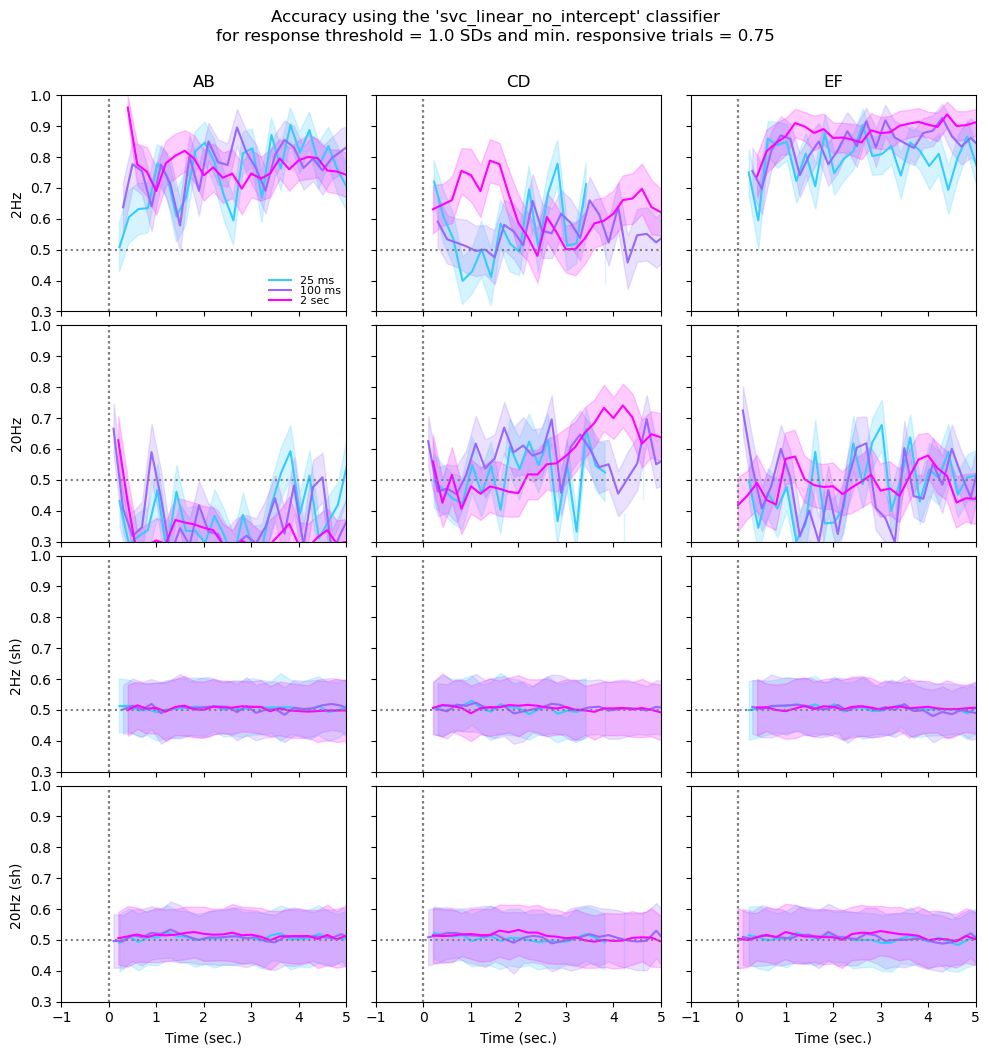

In [16]:
plot_wsz_results("l2", what_to_plot = "acc", yl = (0.3, 1), show_shuf = True, show_error_bars = True, which_sizes = [0.025,0.1,2], export_figure = True)

## Nonlinear kernels: Polynomial

Wrote acc_1.0_0.75_poly.pdf


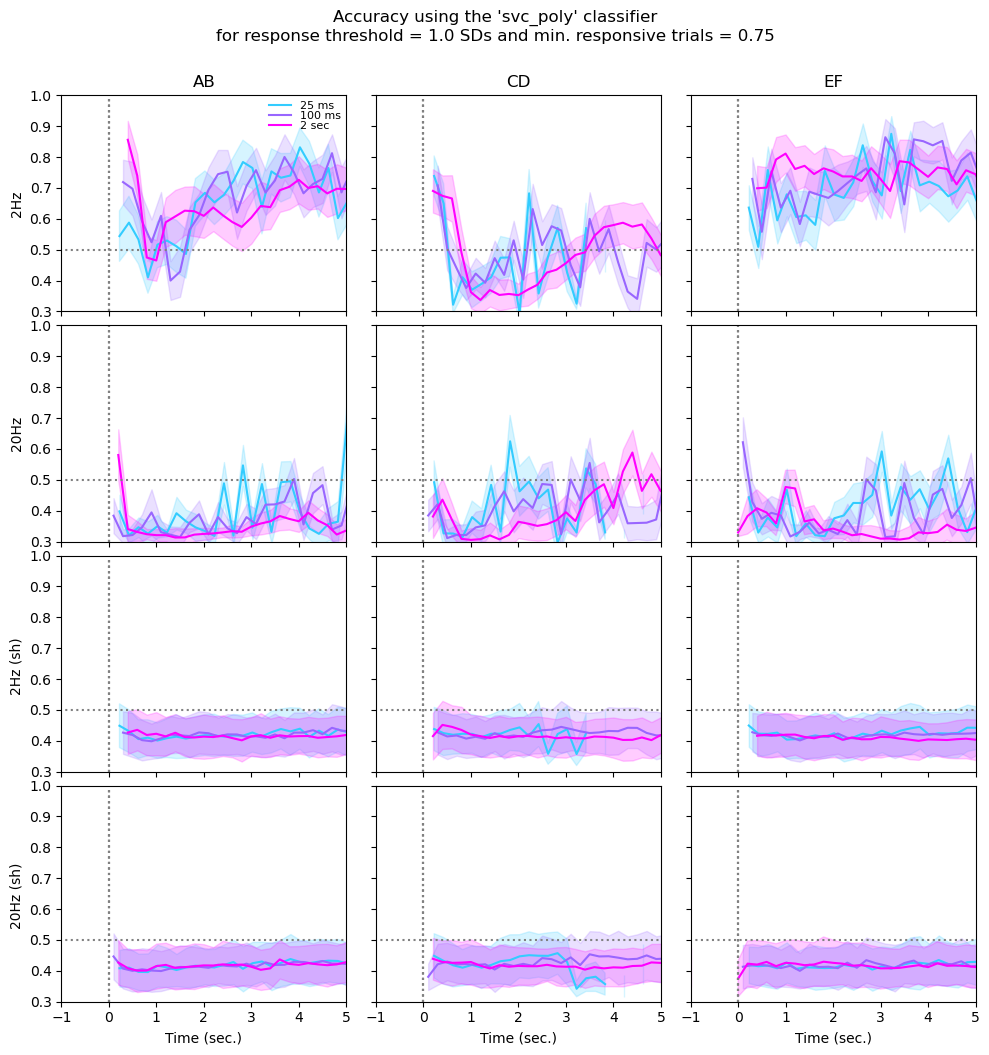

In [17]:
plot_wsz_results("poly", what_to_plot = "acc", yl = (0.3, 1), show_shuf = True, show_error_bars = True, which_sizes = [0.025,0.1,2], export_figure = True)

## Nonlinear kernels: RBF

Wrote acc_1.0_0.75_rbf.pdf


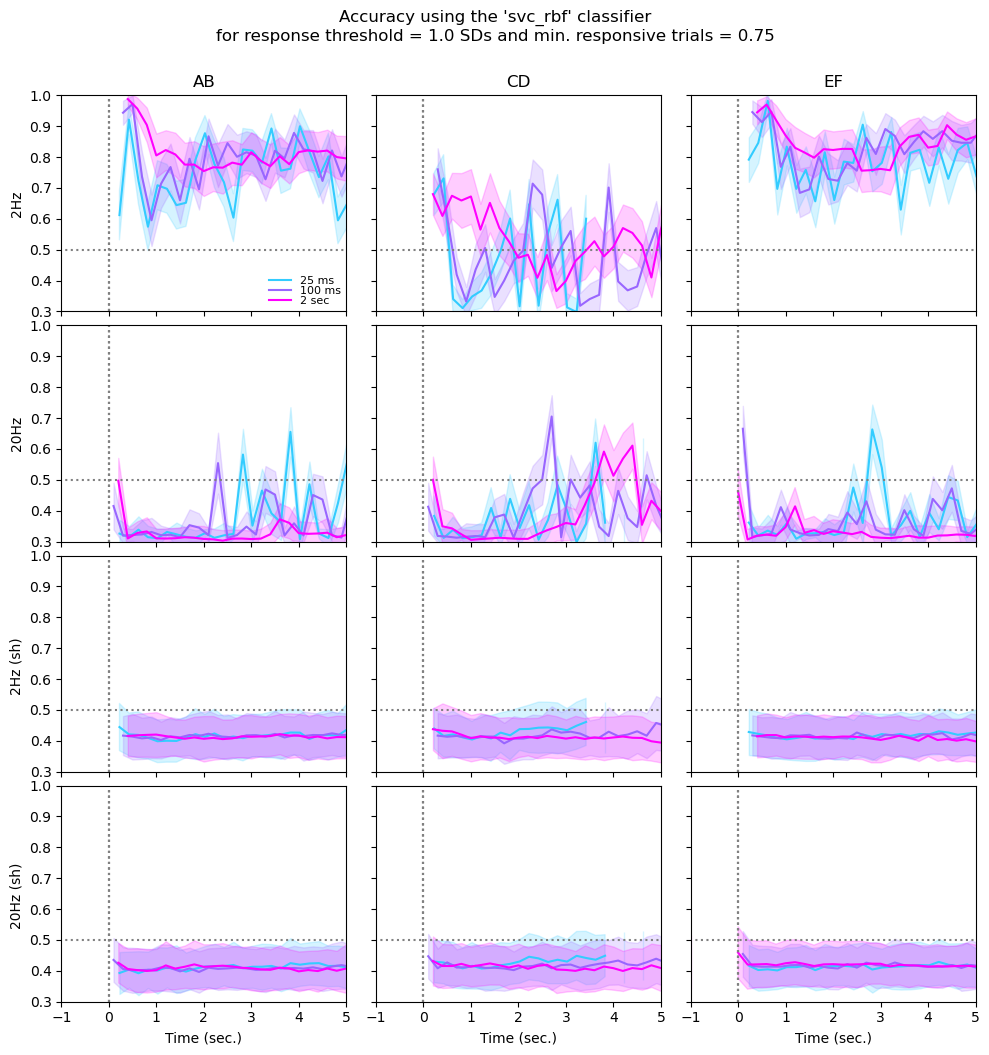

In [18]:
plot_wsz_results("rbf", what_to_plot = "acc", yl = (0.3, 1), show_shuf = True, show_error_bars = True, which_sizes = [0.025,0.1,2], export_figure = True)

# Inspecting Decoding Performance

In [ ]:
wsz  = 2
freq = 20
pair = "CD"
whis = "yes"
odour_onset = 3
#which_start_time = 9.6
#start_time = which_start_time + odour_onset
start_time = 9
response_threshold = 3.
min_resp_trials = 0.75
conf = inputs.Config(seed=0,shuf=0, window_size = wsz, n_sub = 145, freq = freq, pairs = pair, whiskers = whis, start_time = start_time)
best_coefs, (X,y,t,X_sub,ind_glom,ind_t) = get_best_coefs(conf, "lasso_lars_no_intercept",
                                                          compute_accuracy = True,
                                                          full = True,
                                                          response_threshold = response_threshold,
                                                          min_resp_trials = min_resp_trials)
X_sub_max   = np.max(X_sub, axis=0)
coefs_order = argsort(best_coefs)
#xx,yy,ss,nn = xysnf[pair, wsz, 0, freq, response_threshold, min_resp_trials]
#xx,yy,ss = xys[name, pair, wsz, False,freq]            

In [ ]:
dt = (t[1]-t[0])/2
which_ranked_coef = -1
icoef = coefs_order[which_ranked_coef]
roi = ind_glom[icoef]
gs = GridSpec(4,2)
figure(figsize=(8,8))
subplot(gs[0,:2])

# We're going to plot everything by the _end_ time of the window
if False:
    tt = xx - odour_onset + wsz 
    fill_between(tt, yy - ss, yy + ss, color=list(mcolors.to_rgb(wsz_cols[wsz]))+[0.2])
    plot(tt,yy, ".-", color=wsz_cols[wsz], label = wsz_labs[wsz])
    indt = argmin(abs(xx - start_time))
    plot(tt[indt], yy[indt],"ro", markersize=10)
    ylim(0.3,1); xlabel("Time (sec.",labelpad=-1); ylabel("Accuracy"); vline(0, ":", color="gray");
    title(f"Odour {pair} at {freq} Hz decoded from a {wsz_labs[wsz]} window ending at t = {start_time - odour_onset + wsz:1.3f} sec.")
    xlim(tt[0]- wsz, tt[-1])
    
subplot(gs[1,0]);
stem(best_coefs, basefmt="C0", markerfmt = ".", use_line_collection = True); xlabel("ROI"); ylabel("Coefficient"); plot(icoef, best_coefs[icoef], "o", color="red")
title(f"Decoding Coefficients (ROI {roi} highlighted)")

#Z = copy(X) #(X - mean(X,axis=0))/std(X,axis=0)
subplot(gs[1,1]); plot(X[y>0, icoef], [1]*sum(y>0), "ro"); plot(X[y<0, icoef], [-1]*sum(y<0), "bo");
ylim([-1.5,1.5]); gca().set_yticks([-1,1]); gca().set_yticklabels(["anti-corr","corr"],rotation=90, verticalalignment="center");
xlabel("Response"); title(f"Responses of ROI {roi}")

subplot(gs[2,:]); plot_timecourses(X_sub[:, icoef, :],y, t - odour_onset)
wnd_start = t[ind_t[0]] - odour_onset - dt/2; wnd_end = t[ind_t[-1]] - odour_onset + dt/2;#xx[indt] - odour_onset; wnd_end   = wnd_start + wsz
vline(wnd_start, ":", color="gray",linewidth=2); vline(wnd_end, ":", color="gray", linewidth=2)
#xlim(t[0]-odour_onset, t[-1]-odour_onset)
xlim(tt[0]- wsz, tt[-1])
title(f"Timecourse of ROI {roi}"); ylabel("dF / F");

subplot(gs[3,:])
xl = [wnd_start - min(10*wsz, 1), wnd_end + min(10*wsz,1)]
indt_xl = where((t - odour_onset > xl[0]) & (t - odour_onset < xl[1]))[0]
t_xl = t[indt_xl] - odour_onset
plot_timecourses(X_sub[:, icoef, indt_xl],y, t_xl, style=".-")
xlim(t_xl[0], t_xl[-1]); vline(wnd_start, ":", color="gray"); vline(wnd_end, ":", color="gray");
title(f"Timecourse of ROI {roi} zoomed on decoding window"); xlabel("Time (sec.)"); ylabel("dF / F");
tight_layout(h_pad=0, w_pad=0.2)
fig_name = f"{pair}_{freq}Hz_wsz{wsz:1.3f}_{which_start_time:1.1f}_ROI{roi}.pdf"
print(fig_name)
#savefig(fig_name, bbox_inches = "tight")